<a href="https://colab.research.google.com/github/karenghanem55-arch/MMM-System-Identification-Benchmark/blob/main/Telecom_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Success: 'mmm_data.csv' has been created.
        week    spend_meta  spend_snapchat  spend_google_search  spend_tiktok  \
0 2023-01-01  11968.396949    20160.486493         12012.585618   7726.798473   
1 2023-01-08   7472.323651     4641.970182          8846.216261   3452.963678   
2 2023-01-15   6911.417922    33510.065024         11671.384224   6222.297175   
3 2023-01-22   6911.511472     2927.494035          7740.586291   1079.680775   
4 2023-01-29  23248.572061    30139.599111         11059.608356   2752.974092   

   saudi_national_day  ramadan_season  acquisitions  
0                   0               0         10547  
1                   0               0          7230  
2                   0               0         11861  
3                   0               0          6573  
4                   0               0         11988  


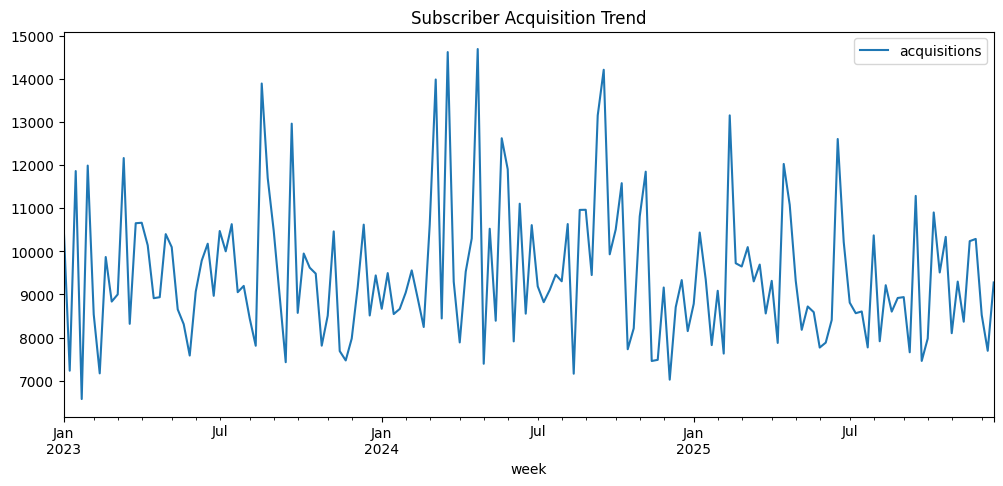

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Setup - 3 Years of Weekly Data (2023-2026)
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=156, freq='W')
df = pd.DataFrame({'week': dates})

# 2. Simulate Media Spend (Independent Variables)
# These represent the weekly checks Jawwy writes to each platform
df['spend_meta'] = np.random.gamma(shape=2, scale=5000, size=156)
df['spend_snapchat'] = np.random.gamma(shape=2, scale=7000, size=156)
df['spend_google_search'] = np.random.normal(loc=10000, scale=2000, size=156)
df['spend_tiktok'] = np.random.gamma(shape=1.5, scale=4000, size=156)

# 3. Add Control Variables (External Factors)
# Saudi National Day (Sept 23rd)
df['saudi_national_day'] = df['week'].apply(lambda x: 1 if x.month == 9 and 20 <= x.day <= 26 else 0)

# Ramadan/Eid Seasonality
df['ramadan_season'] = df['week'].apply(lambda x: 1 if x.month in [3, 4] else 0)

# 4. Generate the Target Variable (New Subscriber Acquisitions)
# As a Data Scientist, you are defining the 'Ground Truth' here
baseline = 5000
acq_meta = (df['spend_meta'] ** 0.8) * 0.5        # Diminishing returns (Power of 0.8)
acq_snap = (df['spend_snapchat'] ** 0.85) * 0.7  # Stronger ROI for Telco in KSA
acq_google = df['spend_google_search'] * 0.1     # High-intent, lower volume
acq_tiktok = (df['spend_tiktok'] ** 0.75) * 0.4

# Combine everything into the final KPI
df['acquisitions'] = (
    baseline +
    acq_meta + acq_snap + acq_google + acq_tiktok +
    (df['saudi_national_day'] * 2000) +
    (df['ramadan_season'] * 800) +
    np.random.normal(0, 200, 156)
).astype(int)

# 5. Export and Preview
df.to_csv('mmm_data.csv', index=False)
print("✅ Success: 'mmm_data.csv' has been created.")
print(df.head())

# Quick Visualization to check the 'Pulse' of the business
df.plot(x='week', y='acquisitions', figsize=(12, 5), title="Subscriber Acquisition Trend")
plt.show()





In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare features (X) and target (y)
X = df[['spend_meta', 'spend_snapchat', 'spend_google_search', 'spend_tiktok', 'saudi_national_day', 'ramadan_season']]
y = df['acquisitions']

# Train/Test Split (Pro move: Use the last 6 months as a holdout set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

# Output the "Discovered" ROI
for col, coef in zip(X.columns, model.coef_):
    print(f"Channel: {col} | Discovered Impact: {coef:.4f}")

Channel: spend_meta | Discovered Impact: 0.0598
Channel: spend_snapchat | Discovered Impact: 0.1357
Channel: spend_google_search | Discovered Impact: 0.1100
Channel: spend_tiktok | Discovered Impact: 0.0305
Channel: saudi_national_day | Discovered Impact: 2185.8871
Channel: ramadan_season | Discovered Impact: 773.7863


In [ ]:
# Calculate the ROI for each channel
results = model.params[1:5]  # Get coefficients for the 4 spend channels
total_spend = X.iloc[:, 1:5].sum()
total_contribution = (X.iloc[:, 1:5] * results).sum()

roi_df = pd.DataFrame({
    'Total Spend (SAR)': total_spend.values,
    'Sign-ups Driven': total_contribution.values.astype(int),
    'CPA (SAR per Sign-up)': (total_spend.values / total_contribution.values).round(2)
}, index=['Meta', 'Snapchat', 'Google', 'TikTok'])

print("--- MEDIA EFFICIENCY REPORT ---")
print(roi_df)


--- MEDIA EFFICIENCY REPORT ---
          Total Spend (SAR)  Sign-ups Driven  CPA (SAR per Sign-up)
Meta           1.525633e+06            88828                  17.17
Snapchat       2.171582e+06           296836                   7.32
Google         1.565382e+06           166571                   9.40
TikTok         9.885713e+05            28789                  34.34


In [ ]:
import statsmodels.api as sm

# Prepare the data
X = df[['spend_meta', 'spend_snapchat', 'spend_google_search', 'spend_tiktok', 'saudi_national_day', 'ramadan_season']]
X = sm.add_constant(X) # This helps the model 'find' the 5000 baseline
y = df['acquisitions']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Conclusion Table
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           acquisitions   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1221.
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          5.95e-124
Time:                        13:08:09   Log-Likelihood:                -1067.8
No. Observations:                 156   AIC:                             2150.
Df Residuals:                     149   BIC:                             2171.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5587.6669    